In [9]:
!pip install fasttext xgboost --quiet

import fasttext.util
import fasttext
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_auc_score, roc_curve
)
import os
import joblib

In [ ]:
fasttext.util.download_model('pl', if_exists='ignore')

In [2]:
ft_model = fasttext.load_model('cc.pl.300.bin')

In [10]:
def get_ft_vector(text):
    cleaned_text = str(text).replace('\n', ' ').strip()
    return ft_model.get_sentence_vector(cleaned_text)

In [11]:
def load_and_embed(file_path):
    df = pd.read_csv(file_path)
    X = np.vstack(df['Text'].apply(get_ft_vector))
    y = df['Class'].values
    return X, y

In [ ]:
def train_evaluate_xgb(X, y, param_grid, title="XGBoost_Model"):
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

    clf = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
    cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)

    grid_search = GridSearchCV(clf, param_grid, cv=cv, scoring='f1', n_jobs=-1, verbose=1)
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_

    y_pred = best_model.predict(X_test)
    y_proba = best_model.predict_proba(X_test)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_proba)
    cm = confusion_matrix(y_test, y_pred)

    print(f"\n📌 {title} – Best Params:")
    print(grid_search.best_params_)
    print(f"Najlepszy wynik F1 z walidacji krzyżowej: {grid_search.best_score_:.4f}")

    print(f"\n📊 Score ({title}):")
    print(f"Accuracy:  {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall:    {rec:.4f}")
    print(f"F1-score:  {f1:.4f}")
    print(f"ROC AUC:   {auc:.4f}")
    print("\nConfusion Matrix:\n", cm)

    print("\nClassification Report:\n")
    print(classification_report(y_test, y_pred, zero_division=0))

    save_dir = f"{title}_results"
    os.makedirs(save_dir, exist_ok=True)

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title("Confusion Matrix for XGB - The Best Varian")
    plt.xlabel("Prediction")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, f"{title}_confusion_matrix.png"))
    plt.show()

    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, label=f'AUC = {auc:.4f}')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve for XGB - The Best Varian")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, f"{title}_roc_curve.png"))
    plt.show()

    model_path = os.path.join(save_dir, f"{title}.joblib")
    joblib.dump(best_model, model_path)
    print(f"✅ Model zapisany do: {model_path}")

In [13]:
X_raw, y_raw = load_and_embed('BAN-PL_raw.csv')
X_pre, y_pre = load_and_embed('BAN-PL_light.csv')
X_full, y_full = load_and_embed('BAN-PL_full.csv')

In [14]:
param_grid_xgb = {
    'n_estimators': [100, 300],
    'max_depth': [4, 6],
    'learning_rate': [0.1, 0.2],
    'subsample': [0.8, 1.0],
}

Fitting 4 folds for each of 16 candidates, totalling 64 fits


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [12:25:21] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



📌 XGBoost – Raw data – Best Params:
{'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 300, 'subsample': 1.0}
Najlepszy wynik F1 z walidacji krzyżowej: 0.8320

📊 Score (XGBoost – Raw data):
Accuracy:  0.8358
Precision: 0.8424
Recall:    0.8263
F1-score:  0.8342
ROC AUC:   0.9181

Confusion Matrix:
 [[2029  371]
 [ 417 1983]]

Classification Report:

              precision    recall  f1-score   support

           0       0.83      0.85      0.84      2400
           1       0.84      0.83      0.83      2400

    accuracy                           0.84      4800
   macro avg       0.84      0.84      0.84      4800
weighted avg       0.84      0.84      0.84      4800



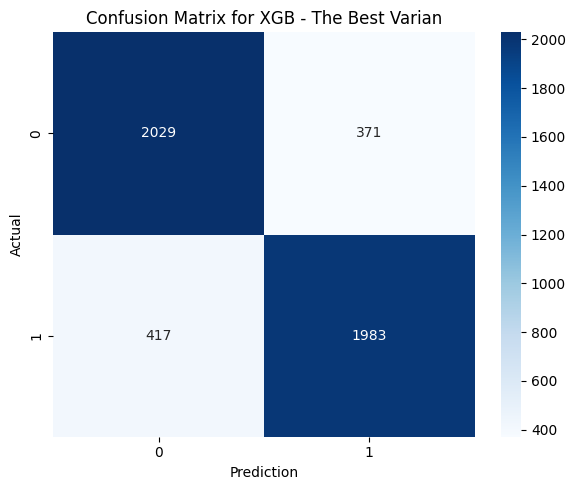

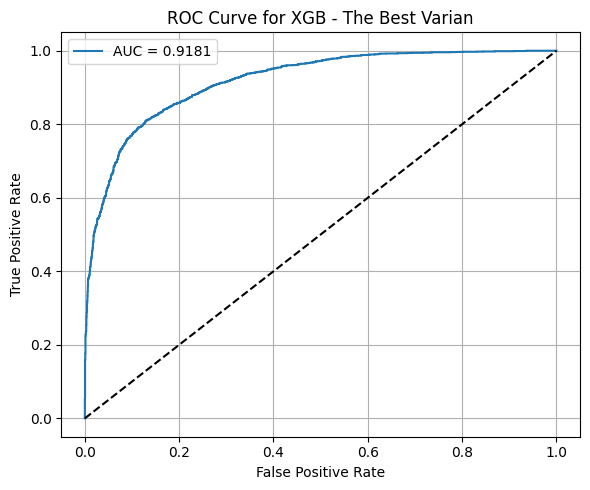

✅ Model zapisany do: XGBoost – Raw data_results/XGBoost – Raw data.joblib


In [17]:
train_evaluate_xgb(X_raw, y_raw, param_grid_xgb, title="XGBoost – Raw data")

Fitting 4 folds for each of 16 candidates, totalling 64 fits


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [12:55:13] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



📌 XGBoost – Preprocessed data – Best Params:
{'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 300, 'subsample': 0.8}
Najlepszy wynik F1 z walidacji krzyżowej: 0.8258

📊 Score (XGBoost – Preprocessed data):
Accuracy:  0.8273
Precision: 0.8308
Recall:    0.8218
F1-score:  0.8263
ROC AUC:   0.9064

Confusion Matrix:
 [[1998  401]
 [ 427 1969]]

Classification Report:

              precision    recall  f1-score   support

           0       0.82      0.83      0.83      2399
           1       0.83      0.82      0.83      2396

    accuracy                           0.83      4795
   macro avg       0.83      0.83      0.83      4795
weighted avg       0.83      0.83      0.83      4795



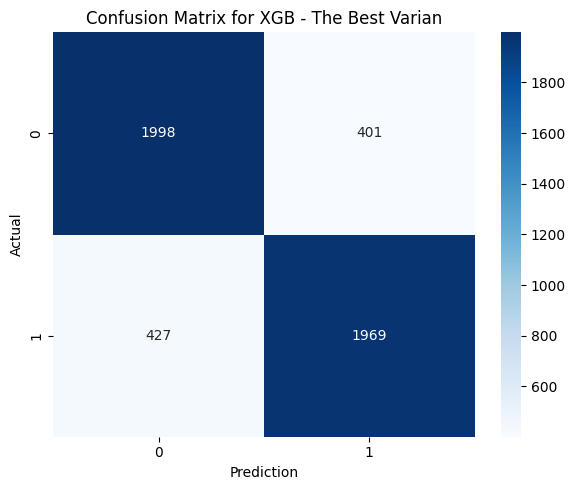

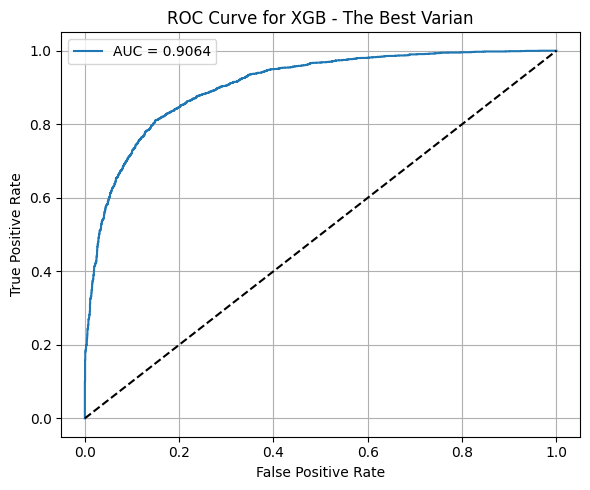

✅ Model zapisany do: XGBoost – Preprocessed data_results/XGBoost – Preprocessed data.joblib


In [18]:
train_evaluate_xgb(X_pre, y_pre, param_grid_xgb, title="XGBoost – Preprocessed data")

Fitting 4 folds for each of 16 candidates, totalling 64 fits


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [13:21:03] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



📌 XGBoost – Fully processed data – Best Params:
{'learning_rate': 0.2, 'max_depth': 4, 'n_estimators': 300, 'subsample': 0.8}
Najlepszy wynik F1 z walidacji krzyżowej: 0.8339

📊 Score (XGBoost – Fully processed data):
Accuracy:  0.8278
Precision: 0.8413
Recall:    0.8083
F1-score:  0.8245
ROC AUC:   0.9093

Confusion Matrix:
 [[2026  365]
 [ 459 1935]]

Classification Report:

              precision    recall  f1-score   support

           0       0.82      0.85      0.83      2391
           1       0.84      0.81      0.82      2394

    accuracy                           0.83      4785
   macro avg       0.83      0.83      0.83      4785
weighted avg       0.83      0.83      0.83      4785



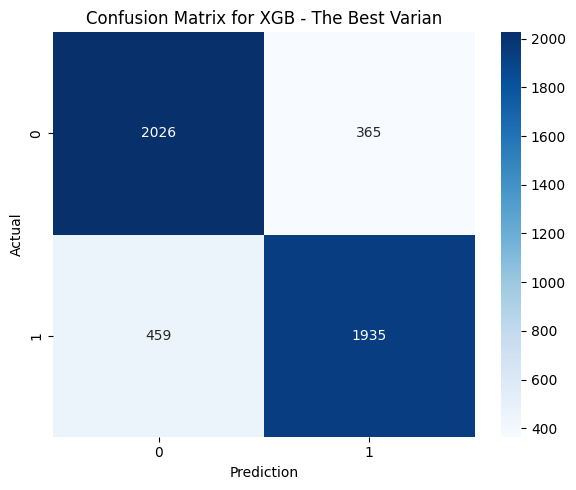

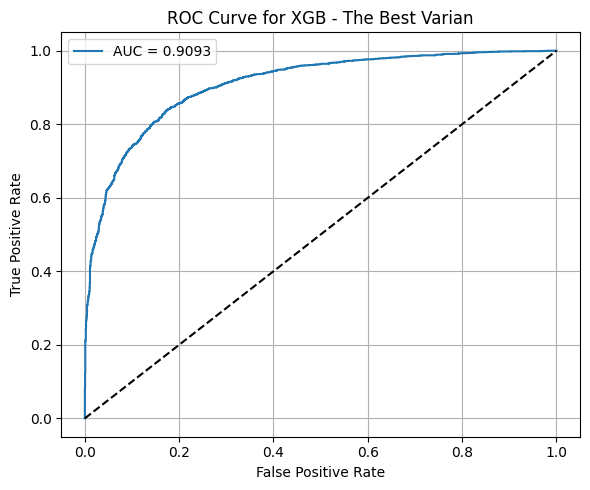

✅ Model zapisany do: XGBoost – Fully processed data_results/XGBoost – Fully processed data.joblib


In [19]:
train_evaluate_xgb(X_full, y_full, param_grid_xgb, title="XGBoost – Fully processed data")